In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Librerias

In [2]:
#This code uses 3D Unet to train a network on 3D subvolumes (64x64x64).
#It also segments a large volume and outputs a multidimensional OMETIFF file
#Custom dataset is used for this code but it should work on any dataset, including BRATS.

In [3]:
#Latest Tensorflow (2.4) is giving error for some of the libraries we will be using,
# especially segmentation models 3D.
#Therefore, I am defining TF version 1.x.
#If you have your own 3D unet model, you can try the latest TF version.
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [4]:
#Install all dependencies for sgementation-models-3D library.
#We will use this library to call 3D unet.
#Alternative, you can define your own Unet, if you have skills!
!pip install classification-models-3D
!pip install efficientnet-3D
!pip install segmentation-models-3D

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.5/69.5 kB 701.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 91.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 107.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 51.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 101.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 79.4 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Unins

In [5]:
#Use patchify to break large volumes into smaller for training
#and also to put patches back together after prediction.
!pip install patchify

In [6]:
import tensorflow as tf
import keras
print(tf.__version__)
print(keras.__version__)

2.8.0
2.8.0


In [7]:
#Make sure the GPU is available.
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [8]:
import segmentation_models_3D as sm


Segmentation Models: using `tf.keras` framework.


In [9]:
from skimage import io
from patchify import patchify, unpatchify
import numpy as np
from matplotlib import pyplot as plt
from keras import backend as K
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import cv2

# Data Loading

In [ ]:
path_images = '/content/drive/MyDrive/Project/GK_Unet/GK.467_1_train_img.tiff'
path_masks = '/content/drive/MyDrive/Project/GK_Unet/GK.467_1_train_mask.tiff'

In [ ]:
#Load input images and masks.
#Here we load 256x256x256 pixel volume. We will break it into patches of 64x64x64 for training.
image = io.imread(path_images)
img_patches = patchify(image, (64, 64, 64), step=64)  #Step=64 for 64 patches means no overlap

mask = io.imread(path_masks)
mask_patches = patchify(mask, (64, 64, 64), step=64)


In [ ]:
input_img = np.reshape(img_patches, (-1, img_patches.shape[3], img_patches.shape[4], img_patches.shape[5]))
input_mask = np.reshape(mask_patches, (-1, mask_patches.shape[3], mask_patches.shape[4], mask_patches.shape[5]))

print(input_img.shape)  # (n_patches, x, y, z)



# Data split

In [ ]:
import os
from skimage import io
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Rutas a las carpetas de tus imágenes y máscaras
path_images_folder = '/content/drive/MyDrive/Project/GK_Unet/Img/'
path_masks_folder = '/content/drive/MyDrive/Project/GK_Unet/Maskbin/'

# Lista de rutas de tus imágenes y máscaras
path_images_list = [os.path.join(path_images_folder, img) for img in os.listdir(path_images_folder)]
path_masks_list = [os.path.join(path_masks_folder, mask) for mask in os.listdir(path_masks_folder)]

train_img_list = []
train_mask_list = []
count=0
for path_images, path_masks in zip(path_images_list, path_masks_list):
    # Cargar imágenes y máscaras
    image = io.imread(path_images)
    mask = io.imread(path_masks)

    # Dividir en parches de 64x64x64
    img_patches = patchify(image, (64, 64, 64), step=64)
    mask_patches = patchify(mask, (64, 64, 64), step=64)

    # Reformar
    input_img = np.reshape(img_patches, (-1, img_patches.shape[3], img_patches.shape[4], img_patches.shape[5]))
    input_mask = np.reshape(mask_patches, (-1, mask_patches.shape[3], mask_patches.shape[4], mask_patches.shape[5]))

    # Convertir imagen en escala de grises a 3 canales
    train_img = np.stack((input_img,)*3, axis=-1)
    train_mask = np.expand_dims(input_mask, axis=4)

    # Agregar a las listas
    train_img_list.append(train_img)
    train_mask_list.append(train_mask)
    print(count, ': ',round(count/len(path_images_list)*100),'%')
    count = count+1


# Concatenar todas las imágenes y máscaras
train_img = np.concatenate(train_img_list, axis=0)
train_mask = np.concatenate(train_mask_list, axis=0)
n_classes =2
# Convertir máscaras a categóricas
train_mask_cat = to_categorical(train_mask, num_classes=n_classes)

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(train_img, train_mask_cat, test_size = 0.10, random_state = 0)


0 :  0 %
1 :  2 %
2 :  5 %
3 :  8 %
4 :  10 %
5 :  12 %
6 :  15 %
7 :  18 %
8 :  20 %
9 :  22 %
10 :  25 %
11 :  28 %
12 :  30 %
13 :  32 %
14 :  35 %
15 :  38 %
16 :  40 %
17 :  42 %
18 :  45 %
19 :  48 %
20 :  50 %
21 :  52 %
22 :  55 %
23 :  57 %
24 :  60 %
25 :  62 %
26 :  65 %
27 :  68 %
28 :  70 %
29 :  72 %
30 :  75 %
31 :  78 %
32 :  80 %
33 :  82 %
34 :  85 %
35 :  88 %
36 :  90 %
37 :  92 %
38 :  95 %
39 :  98 %


In [ ]:
train_mask.shape

(2560, 64, 64, 64, 1)

In [ ]:
#n_classes= 6

#Convert grey image to 3 channels by copying channel 3 times.
#We do this as our unet model expects 3 channel input.

#train_img = np.stack((input_img,)*3, axis=-1)
#train_mask = np.expand_dims(input_mask, axis=4) #Para la mascara solo se espera un canal


#train_mask_cat = to_categorical(train_mask, num_classes=n_classes)


#X_train, X_test, y_train, y_test = train_test_split(train_img, train_mask_cat, test_size = 0.10, random_state = 0)
#70% training 30% testing


# Model parameters

In [ ]:

# Loss Function and coefficients to be used during training:
def dice_coefficient(y_true, y_pred):
    smoothing_factor = 1
    flat_y_true = K.flatten(y_true)
    flat_y_pred = K.flatten(y_pred)
    return (2. * K.sum(flat_y_true * flat_y_pred) + smoothing_factor) / (K.sum(flat_y_true) + K.sum(flat_y_pred) + smoothing_factor)

def dice_coefficient_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)


Backbones: ['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'seresnet18', 'seresnet34', 'seresnet50', 'seresnet101', 'seresnet152', 'seresnext50', 'seresnext101', 'senet154', 'resnext50', 'resnext101', 'vgg16', 'vgg19', 'densenet121', 'densenet169', 'densenet201', 'inceptionresnetv2', 'inceptionv3', 'mobilenet', 'mobilenetv2', 'efficientnetb0', 'efficientnetb1', 'efficientnetb2', 'efficientnetb3', 'efficientnetb4', 'efficientnetb5', 'efficientnetb6', 'efficientnetb7']

In [ ]:
#Define parameters for our model.

encoder_weights = 'imagenet'
BACKBONE = 'vgg16'  #Try vgg16, efficientnetb7, inceptionv3, resnet50
activation = 'softmax'
patch_size = 64
n_classes = 2
channels=3

LR = 0.0001
optim = tf.keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.5, 0.5])) # se corresponden al número de clases
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [ ]:
preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
#Preprocess input data - otherwise you end up with garbage resutls
# and potentially model that does not converge.
X_train_prep = preprocess_input(X_train)
X_test_prep = preprocess_input(X_test)

In [ ]:
#Define the model. Here we use Unet but we can also use other model architectures from the library.
model = sm.Unet(BACKBONE, classes=n_classes,
                input_shape=(patch_size, patch_size, patch_size, channels),
                encoder_weights=encoder_weights,
                activation=activation)

model.compile(optimizer = optim, loss=total_loss, metrics=metrics)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 64,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv3D)          (None, 64, 64, 64,   5248        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 block1_conv2 (Conv3D)          (None, 64, 64, 64,   110656      ['block1_conv1[0][0]']           
                                64)                                                           

# Training

In [ ]:
#Fit the model
history = model.fit(X_train_prep,
          y_train,
          batch_size=8,
          epochs=100,
          verbose=1,
          validation_data=(X_test_prep, y_test))

Epoch 1/100
288/288 [==============================] - 70s 184ms/step - loss: 0.7642 - iou_score: 0.6110 - f1-score: 0.6140 - val_loss: 0.7536 - val_iou_score: 0.8280 - val_f1-score: 0.8281
Epoch 2/100
288/288 [==============================] - 50s 172ms/step - loss: 0.7513 - iou_score: 0.8211 - f1-score: 0.8211 - val_loss: 0.7506 - val_iou_score: 0.8280 - val_f1-score: 0.8281
Epoch 3/100
288/288 [==============================] - 50s 172ms/step - loss: 0.7506 - iou_score: 0.8263 - f1-score: 0.8263 - val_loss: 0.7519 - val_iou_score: 0.8280 - val_f1-score: 0.8281
Epoch 4/100
288/288 [==============================] - 50s 172ms/step - loss: 0.7503 - iou_score: 0.7829 - f1-score: 0.7829 - val_loss: 0.7505 - val_iou_score: 0.8280 - val_f1-score: 0.8281
Epoch 5/100
288/288 [==============================] - 50s 172ms/step - loss: 0.7500 - iou_score: 0.6099 - f1-score: 0.6108 - val_loss: 0.7498 - val_iou_score: 0.5020 - val_f1-score: 0.5037
Epoch 6/100
288/288 [=============================

In [ ]:
#Save model for future use
model.save('/content/drive/MyDrive/Project/Modelos/3D_model_vgg16_100epochs_GK40bin_6_6.h5')

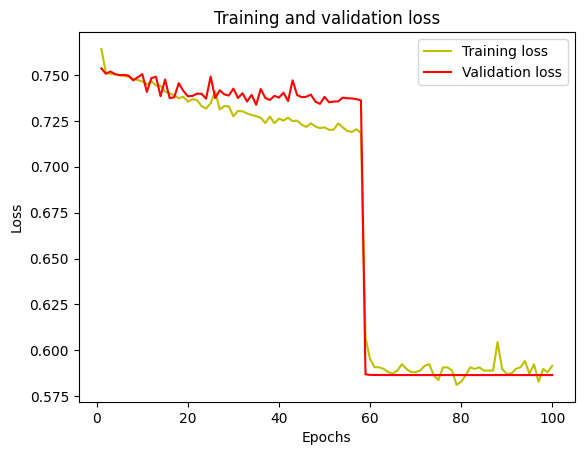

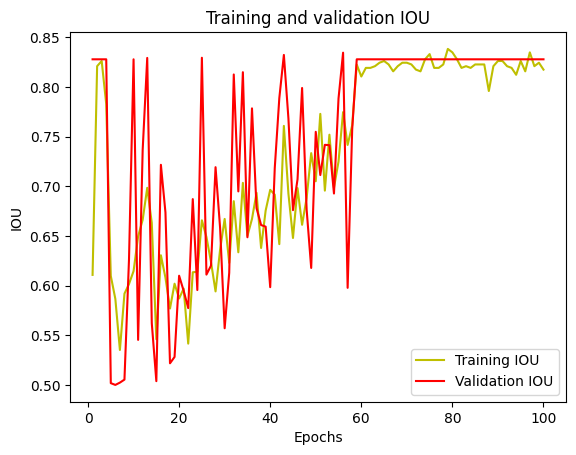

In [ ]:
###
#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

# Load a formerly generated model

In [57]:
#Load the pretrained model for testing and predictions.
from keras.models import load_model
my_model = load_model('/content/drive/MyDrive/Project/Modelos/3D_model_vgg16_100epochs_GK40bin_2_2.h5', compile=False)
#If you load a different model do not forget to preprocess accordingly.

In [ ]:
#Predict on the test data
y_pred=my_model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=4)
y_test_argmax = np.argmax(y_test, axis=4)


NameError: ignored

In [ ]:
print(y_pred_argmax.shape)
print(y_test_argmax.shape)
print(np.unique(y_pred_argmax))

NameError: ignored

In [ ]:
#Using built in keras function for IoU
#Only works on TF > 2.0
#from keras.metrics import MeanIoU
#from keras.metrics import MeanIoU
#n_classes = 4
#IOU_keras = MeanIoU(num_classes=n_classes)
#IOU_keras.update_state(y_test_argmax, y_pred_argmax)
#print("Mean IoU =", IOU_keras.result().numpy())

In [ ]:
#Test some random images
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img, 0)
test_img_input1 = preprocess_input(test_img_input)

test_pred1 = my_model.predict(test_img_input1)
test_prediction1 = np.argmax(test_pred1, axis=4)[0,:,:,:]
print(test_prediction1.shape)




NameError: ignored

In [ ]:
ground_truth_argmax = np.argmax(ground_truth, axis=3)
print(test_img.shape)

(64, 64, 64, 3)


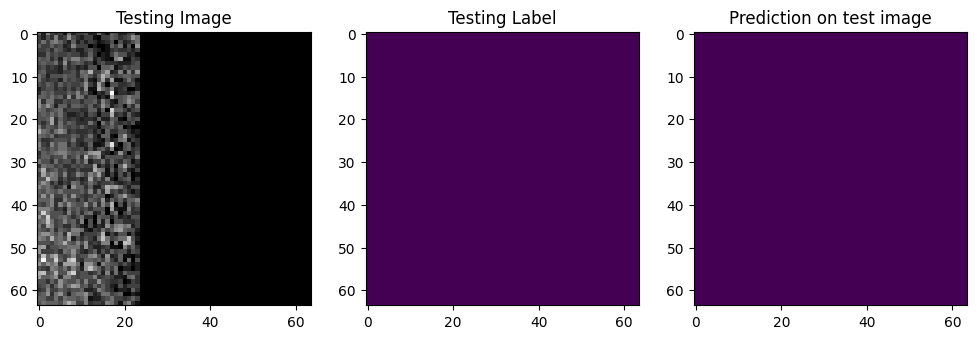

In [ ]:
#Plot individual slices from test predictions for verification
slice = 63
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[slice,:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth_argmax[slice,:,:])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction1[slice,:,:])
plt.show()

Now segment the full volume using the trained model.

# Prediction

In [58]:
import random
#Break the large image (volume) into patches of same size as the training images (patches)
large_image = io.imread('/content/drive/MyDrive/Project/Testing/GK.274_1_train_img.tiff')
patches = patchify(large_image, (64, 64, 64), step=64)  #Step=256 for 256 patches means no overlap
print(large_image.shape)
print(patches.shape)

(256, 256, 256)
(4, 4, 4, 64, 64, 64)


In [59]:
from keras.applications.vgg16 import preprocess_input

# Predict each 3D patch
predicted_patches = []
for i in range(patches.shape[0]):
  for j in range(patches.shape[1]):
    for k in range(patches.shape[2]):
      #print(i,j,k)
      single_patch = patches[i,j,k, :,:,:]
      single_patch_3ch = np.stack((single_patch,)*3, axis=-1)
      single_patch_3ch_input = preprocess_input(np.expand_dims(single_patch_3ch, axis=0))
      single_patch_prediction = my_model.predict(single_patch_3ch_input)
      single_patch_prediction_argmax = np.argmax(single_patch_prediction, axis=4)[0,:,:,:]
      predicted_patches.append(single_patch_prediction_argmax)



In [60]:
#Convert list to numpy array
predicted_patches = np.array(predicted_patches)
print(predicted_patches.shape)

(64, 64, 64, 64)


In [61]:
#Reshape to the shape we had after patchifying
predicted_patches_reshaped = np.reshape(predicted_patches,
                                        (patches.shape[0], patches.shape[1], patches.shape[2],
                                         patches.shape[3], patches.shape[4], patches.shape[5]) )
print(predicted_patches_reshaped.shape)

(4, 4, 4, 64, 64, 64)


In [62]:
#Repach individual patches into the orginal volume shape
reconstructed_image = unpatchify(predicted_patches_reshaped, large_image.shape)
print(reconstructed_image.shape)

(256, 256, 256)


In [63]:
print(reconstructed_image.dtype)

int64


In [64]:
#Convert to uint8 so we can open image in most image viewing software packages
reconstructed_image=reconstructed_image.astype(np.uint8)
print(reconstructed_image.dtype)

uint8


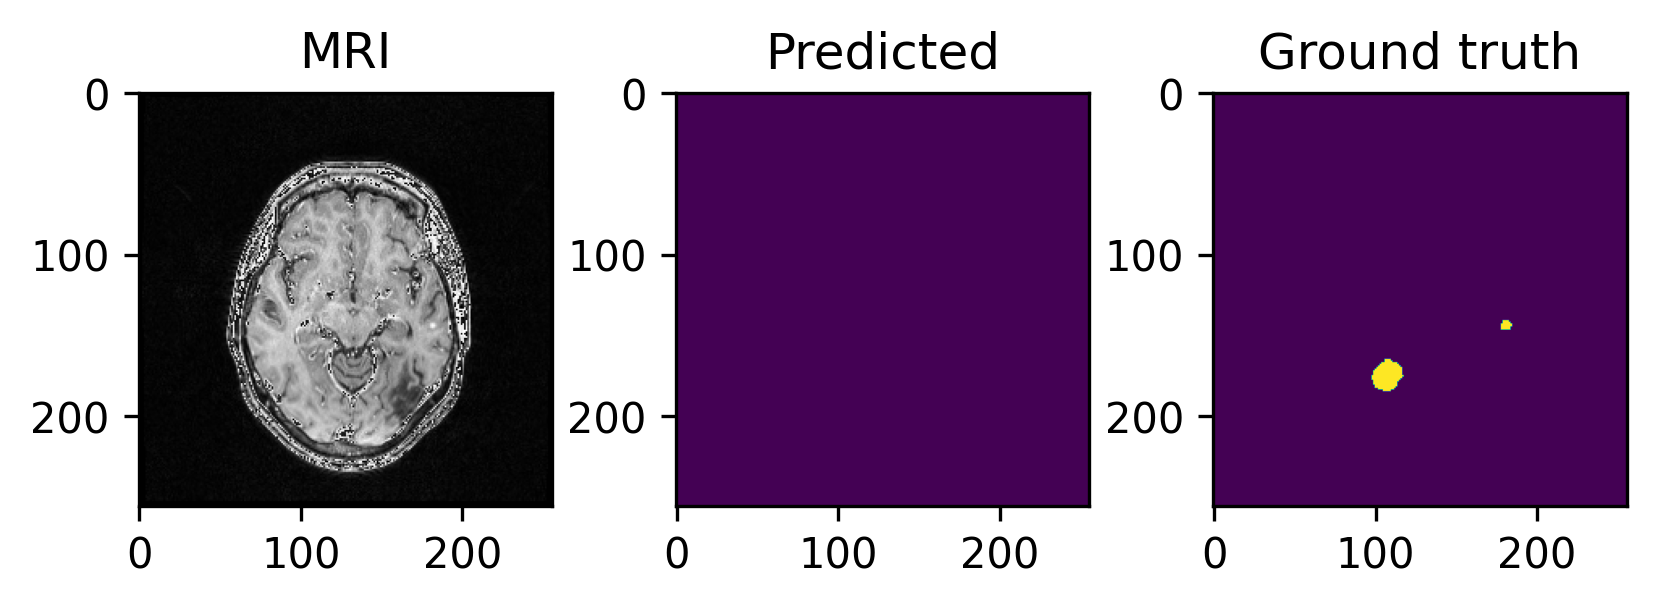

In [65]:
import matplotlib.pyplot as plt
import numpy as np

true_mask = io.imread('/content/drive/MyDrive/Project/Testing/GK.274_1_train_mask.tiff')
true_img = io.imread('/content/drive/MyDrive/Project/Testing/GK.274_1_train_img.tiff')

plt.figure(dpi = 300)

plt.subplot(1,3,1)
plt.imshow(true_img[:,:,115],cmap='gray')
plt.title('MRI')

plt.subplot(1,3,2)
plt.imshow(np.max(reconstructed_image,axis=2))
plt.title('Predicted')

plt.subplot(1,3,3)
plt.imshow(np.max(true_mask,axis=2))
plt.title('Ground truth')

# Aumentar la separación entre los gráficos
plt.subplots_adjust(wspace=0.3)

plt.show()




In [66]:
#Now save it as segmented volume.
from tifffile import imsave
imsave('/content/drive/MyDrive/Project/Prueba/Segmented_GK40bin-455_1.tiff', reconstructed_image)


<ipython-input-66-11599641cb74>:3: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  imsave('/content/drive/MyDrive/Project/Prueba/Segmented_GK40bin-455_1.tiff', reconstructed_image)


In [67]:
print(reconstructed_image.dtype)

uint8


In [68]:
#If you would like to save the volume as multichannel dataset....

In [69]:
print(np.unique(reconstructed_image))

[0]


# Channels

In [ ]:
#Seperate each channel/segment to be combined as multiple channels.
num_segments=4
segm0 = (reconstructed_image == 0)
segm1 = (reconstructed_image == 1)
segm2 = (reconstructed_image == 2)
segm3 = (reconstructed_image == 3)

final = np.empty((reconstructed_image.shape[0], reconstructed_image.shape[1], reconstructed_image.shape[2], num_segments))
final[:,:,:,0] = segm0
final[:,:,:,1] = segm1
final[:,:,:,2] = segm2
final[:,:,:,3] = segm3

In [ ]:
#Use APEER OMETIFF library to read and write multidimensional images
!pip install apeer_ometiff_library

  Using cached apeer_ometiff_library-1.10.1-py3-none-any.whl (19 kB)
  Using cached tifffile-2020.6.3-py3-none-any.whl (133 kB)
  Using cached imagecodecs-2020.5.30.tar.gz (9.0 MB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
from apeer_ometiff_library import io

ModuleNotFoundError: ignored

In [ ]:
# Expand image array to 5D of order (T, Z, C, X, Y)
# This is the convention for OMETIFF format as written by APEER library
final = np.expand_dims(final, axis=0)
final=np.swapaxes(final, 2, 4)

final = final.astype(np.int8)



In [ ]:
print("Shape of the segmented volume is: T, Z, C, X, Y ", final.shape)
print(final.dtype)


In [ ]:
# Write dataset as multi-dimensional OMETIFF *image*
io.write_ometiff("/content/drive/MyDrive/Colab Notebooks/data/sandstone_3d/all_images/segmented_multi_channel.ome.tiff", final)